### **Electricity Load Forecasting**



In [1]:
# #Increase width of notebook
# from IPython.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))

In [7]:
import warnings

#Command to not show warnings
warnings.filterwarnings("ignore")

# **Importing Dependencies**

In [1]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss, grangercausalitytests
from statsmodels.tsa.api import VAR
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.base import datetools
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsforecast import StatsForecast
from statsmodels.tsa.arima.model import ARIMA as sm_arima
from statsforecast.models import ARIMA as sf_arima, AutoARIMA, SeasonalNaive, RandomWalkWithDrift, HistoricAverage
from prophet import Prophet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsforecast/core.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
Importing plotly failed. Interactive plots will not work.


In [ ]:
# #Magic command to enable matplotlib to show plots in Jupyter Notebook
# %matplotlib inline

In [2]:
# Importing the dataset
df_main = pd.read_excel("GEFCom2014-E_a.xlsx")

In [5]:
df_main.head()

,load,T
DateTime,,
2011-01-01 00:00:00,2667.0,34.000000
2011-01-01 01:00:00,2525.0,32.666667
2011-01-01 02:00:00,2417.0,34.000000
2011-01-01 03:00:00,2373.0,36.000000
2011-01-01 04:00:00,2374.0,36.000000


In [4]:
# Converting in the timeseries index
#Merging the data and hour column to form the 'Datetime' column
df_main['DateTime'] = pd.to_datetime(df_main['Date']) + pd.to_timedelta(df_main['Hour'] - 1, unit='h')
df_main.set_index('DateTime',inplace=True)
#Dropping the date and hour column since we don't need them
df_main.drop('Date',axis=1,inplace=True)
df_main.drop('Hour',axis=1,inplace=True)

# **EDA**

In [ ]:
# Checking shape of dataframe
df_main.shape

(35064, 4)

In [ ]:
# Data Summary
df_main.describe(include='all')

,Date,Hour,load,T
count,35064,35064.000000,35064.000000,35064.000000
mean,2012-12-30 23:59:59.999999744,12.500000,3293.448466,47.799519
min,2011-01-01 00:00:00,1.000000,1811.000000,-13.666667
25%,2012-01-01 00:00:00,6.750000,2850.000000,32.666667
50%,2012-12-31 00:00:00,12.500000,3361.000000,48.666667
75%,2013-12-31 00:00:00,18.250000,3682.000000,63.333333
max,2014-12-31 00:00:00,24.000000,5360.000000,97.000000
std,NaN,6.922285,563.201484,19.363532


In [ ]:
# Checking dataframe info
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    35064 non-null  datetime64[ns]
 1   Hour    35064 non-null  int64         
 2   load    35064 non-null  float64       
 3   T       35064 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 1.1 MB


In [ ]:
# Checking Null Values
df_main.isnull().sum()

Date    0
Hour    0
load    0
T       0
dtype: int64

In [87]:
#Lokking at the first 5 data points in the dataset
df_main.head()


,load,T
DateTime,,
2011-01-01 00:00:00,2667.0,34.000000
2011-01-01 01:00:00,2525.0,32.666667
2011-01-01 02:00:00,2417.0,34.000000
2011-01-01 03:00:00,2373.0,36.000000
2011-01-01 04:00:00,2374.0,36.000000


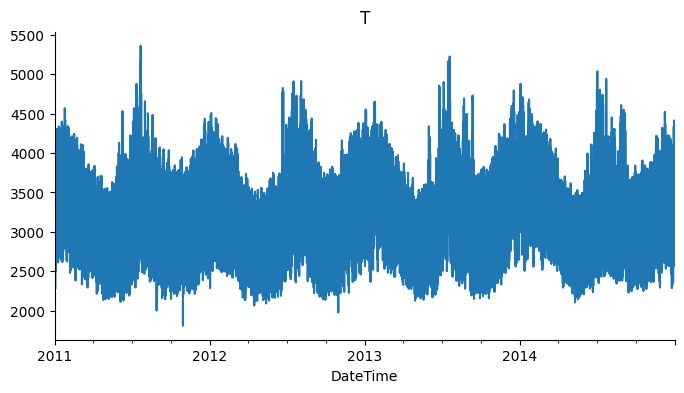

In [ ]:
# Plotting Temperature
df_main['load'].plot(kind='line', figsize=(8, 4), title='T')
plt.gca().spines[['top', 'right']].set_visible(False)

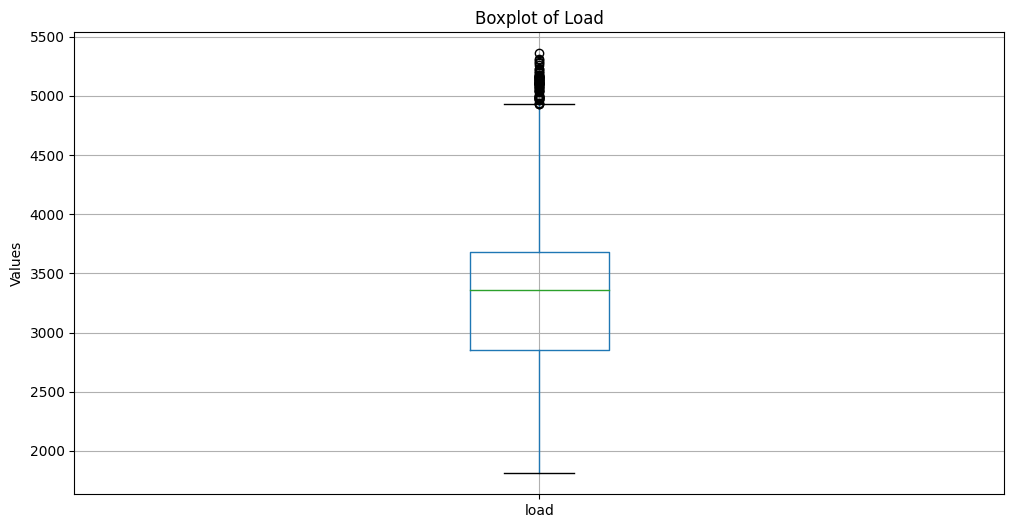

In [ ]:
# Plotting the boxplot
plt.figure(figsize=(12, 6))
df_main[['load']].boxplot()
plt.title('Boxplot of Load')
plt.ylabel('Values')
plt.show()

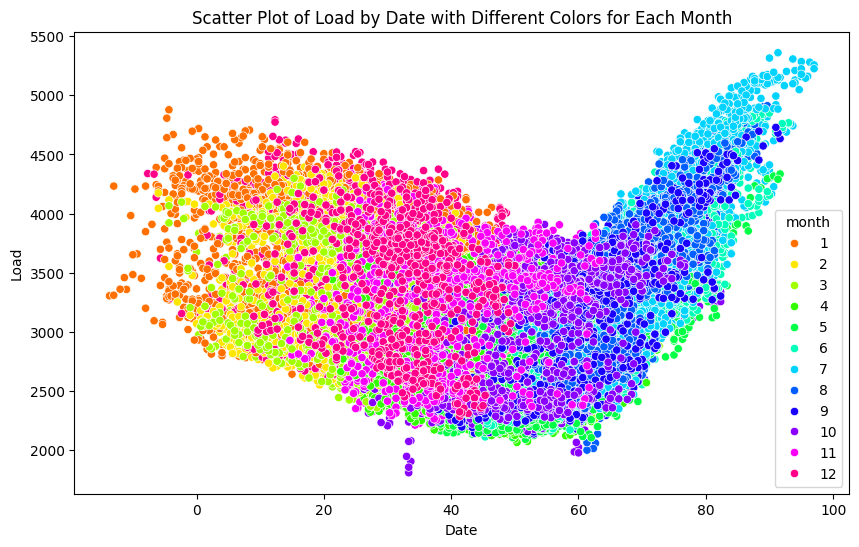

In [88]:
# Plotting scatter plot
df_main['month'] = [df_main.index[i].month for i in range(len(df_main))]
palette = sns.color_palette("hsv", 12)

plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(data=df_main, x='T', y='load', hue='month', palette=palette)

# Add a title and labels
plt.title('Scatter Plot of Load by Date with Different Colors for Each Month')
plt.xlabel('Date')
plt.ylabel('Load')

# Show the plot
plt.show()

In [89]:
del df_main['month']

In [9]:
#Pearson correlation check
df_main.corr()

,load,T
load,1.000000,0.086261
T,0.086261,1.000000


In [ ]:
# Calculate Spearman rank correlation coefficient
spearman_corr = df_main['load'].corr(df_main['T'], method='spearman')

print(f'Spearman rank correlation coefficient between load and T: {spearman_corr}')

Spearman rank correlation coefficient between load and T: 0.07287835457081908


**Temperature do not have linear correlation with Load**

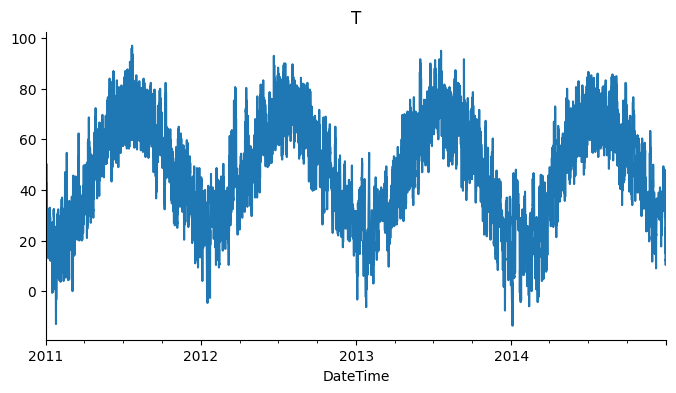

In [ ]:
# Plotting Temperature
df_main['T'].plot(kind='line', figsize=(8, 4), title='T')
plt.gca().spines[['top', 'right']].set_visible(False)

### Time Series Decomposition

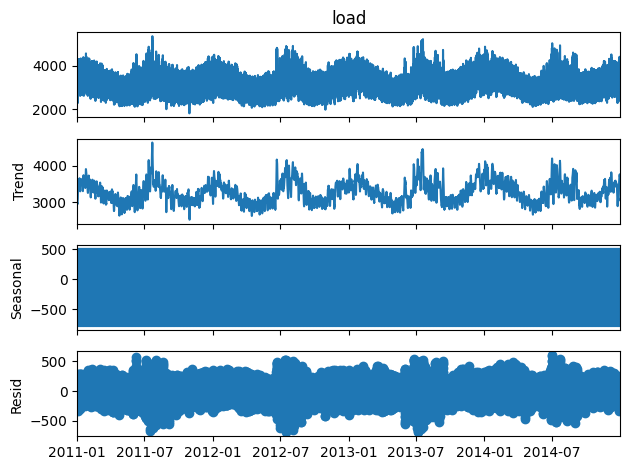

In [10]:
# Additive Decomposition using Seasonal Decompose
result_add = seasonal_decompose(df_main['load'], model = "additive")
result_add.plot();

# Univariate Forecasting

## **Stationarity check**

In [11]:
#KPSS test
kpsstest = kpss(df_main["load"])
kpss_stat = kpsstest[0]
kpss_pval = kpsstest[1]

/var/folders/lt/216p_lfd1jx9d41r9mdhv2y00000gn/T/ipykernel_9557/661466819.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = kpss(df_main["load"])


In [12]:
#Check result
print("stat = %f, pval = %f" % (kpss_stat, kpss_pval))
#Final result
if kpss_pval > 0.05:
    print("The time series is stationary at a 5% significance level")
else:
    print("The time series is not stationary at a 5% significance level")

stat = 0.984616, pval = 0.010000
The time series is not stationary at a 5% significance level


In [14]:
#KPSS test with 1st order difference 
kpsstest = kpss(df_main["load"].diff().dropna())
kpss_stat = kpsstest[0]
kpss_pval = kpsstest[1]

/var/folders/lt/216p_lfd1jx9d41r9mdhv2y00000gn/T/ipykernel_9557/3967935925.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(df_main["load"].diff().dropna())


In [15]:
#Check result
print("stat = %f, pval = %f" % (kpss_stat, kpss_pval))
#Final result
if kpss_pval > 0.05:
    print("The time series is stationary at a 5% significance level")
else:
    print("The time series is not stationary at a 5% significance level")

stat = 0.018719, pval = 0.100000
The time series is stationary at a 5% significance level


In [16]:
#Copying dataset
df_main_st = df_main.copy(deep = True)

In [17]:
#adding difference load series
df_main_st['load_diff'] = df_main_st['load'].diff()

In [18]:
#checking dataframe
df_main_st.head()

,load,T,load_diff
DateTime,,,
2011-01-01 00:00:00,2667.0,34.000000,NaN
2011-01-01 01:00:00,2525.0,32.666667,-142.0
2011-01-01 02:00:00,2417.0,34.000000,-108.0
2011-01-01 03:00:00,2373.0,36.000000,-44.0
2011-01-01 04:00:00,2374.0,36.000000,1.0


## **AutoARIMA with Nixtla**

In [19]:
# getting train and test index stamps
train_start = '2011-01-01 01:00:00'
train_end = '2014-11-30 23:00:00'
test_start = '2014-12-01 00:00:00'
test_end = '2014-12-31 23:00:00'

In [20]:
#Creating train and test dataframe
df_main_st_train = df_main_st[(df_main_st.index>=train_start) & (df_main_st.index<=train_end)]
df_main_st_test = df_main_st[(df_main_st.index>=test_start) & (df_main_st.index<=test_end)]

In [21]:
#Checking dataframe
df_main_st.tail()

,load,T,load_diff
DateTime,,,
2014-12-31 19:00:00,4012.0,18.000000,-187.0
2014-12-31 20:00:00,3856.0,16.666667,-156.0
2014-12-31 21:00:00,3671.0,17.000000,-185.0
2014-12-31 22:00:00,3499.0,15.333333,-172.0
2014-12-31 23:00:00,3345.0,15.333333,-154.0


In [22]:
#Data preprocessing for Nixtla
df_uni_nix = df_main_st["load"].dropna().reset_index()
df_uni_nix["unique_id"] = 1
df_uni_nix.columns = ["ds","y","unique_id"]
df_uni_nix.head()

,ds,y,unique_id
0,2011-01-01 00:00:00,2667.0,1
1,2011-01-01 01:00:00,2525.0,1
2,2011-01-01 02:00:00,2417.0,1
3,2011-01-01 03:00:00,2373.0,1
4,2011-01-01 04:00:00,2374.0,1


In [23]:
#Data preprocessing for Nixtla
df_main_uni_st_train = df_uni_nix[(df_uni_nix['ds']>=train_start) & (df_uni_nix['ds']<=train_end)].reset_index()
df_main_uni_st_test = df_uni_nix[(df_uni_nix['ds']>=test_start) & (df_uni_nix['ds']<=test_end)].reset_index()
del df_main_uni_st_train['index']
del df_main_uni_st_test['index']


In [24]:
#checking dataframe
df_main_uni_st_train.tail()

,ds,y,unique_id
34314,2014-11-30 19:00:00,3706.0,1
34315,2014-11-30 20:00:00,3535.0,1
34316,2014-11-30 21:00:00,3245.0,1
34317,2014-11-30 22:00:00,2954.0,1
34318,2014-11-30 23:00:00,2723.0,1


In [25]:
#Defining splits for cross validation
n_splits = 10
val_size = 744

In [26]:
#Initialize TimeSeriesSplit object
tscv = TimeSeriesSplit(n_splits=n_splits, test_size=val_size)

In [27]:
#Print the indices considered in each split
for fold, (train_index, val_index) in enumerate(tscv.split(df_main_uni_st_train)):
    print("Fold: {}".format(fold))
    print(f"TRAIN indices: {train_index.min()} to {train_index.max()} \n VALIDATION indices: {val_index.min()} to {val_index.max()}")
    print("\n")

Fold: 0
TRAIN indices: 0 to 26878 
 VALIDATION indices: 26879 to 27622


Fold: 1
TRAIN indices: 0 to 27622 
 VALIDATION indices: 27623 to 28366


Fold: 2
TRAIN indices: 0 to 28366 
 VALIDATION indices: 28367 to 29110


Fold: 3
TRAIN indices: 0 to 29110 
 VALIDATION indices: 29111 to 29854


Fold: 4
TRAIN indices: 0 to 29854 
 VALIDATION indices: 29855 to 30598


Fold: 5
TRAIN indices: 0 to 30598 
 VALIDATION indices: 30599 to 31342


Fold: 6
TRAIN indices: 0 to 31342 
 VALIDATION indices: 31343 to 32086


Fold: 7
TRAIN indices: 0 to 32086 
 VALIDATION indices: 32087 to 32830


Fold: 8
TRAIN indices: 0 to 32830 
 VALIDATION indices: 32831 to 33574


Fold: 9
TRAIN indices: 0 to 33574 
 VALIDATION indices: 33575 to 34318




In [78]:
#Initialize MAPE list
mape_ls_arima = []

#Perform time series cross-validation
for fold, (train_index, val_index) in enumerate(tscv.split(df_main_uni_st_train)):

    #Print fold number
    print("Fold: {}".format(fold))

    #Get train and validation fold
    train_fold_df = df_main_uni_st_train.iloc[train_index]
    val_fold_df = df_main_uni_st_train.iloc[val_index]


    #Initialize the Drift model
    #Defining the models
    models_uni = [
        AutoARIMA()
    ]

    sf_uni1 = StatsForecast(df=df_main_uni_st_train.iloc[train_index],
                    models=models_uni,
                    freq='H',
                    n_jobs=-1,
                    fallback_model=SeasonalNaive(season_length=365*24))

    sf_uni1.fit(train_fold_df)

    #Predict for validation fold
    autoarima_forecast = sf_uni1.forecast(h=val_size)

    #Calculate and print MAPE
    val_fold_df["yhat"] = autoarima_forecast["AutoARIMA"].values
    mape = np.round(100*mean_absolute_percentage_error(val_fold_df["y"],val_fold_df["yhat"]),2)
    mape_ls_arima.append(mape)
    print(f"The validation MAPE is {mape}%")

Fold: 0


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsforecast/core.py:399: FutureWarning: The `df` argument of the StatsForecast constructor as well as reusing stored dfs from other methods is deprecated and will raise an error in a future version. Please provide the `df` argument to the corresponding method instead, e.g. fit/forecast.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsforecast/core.py:399: FutureWarning: The `df` argument of the StatsForecast constructor as well as reusing stored dfs from other methods is deprecated and will raise an error in a future version. Please provide the `df` argument to the corresponding method instead, e.g. fit/forecast.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/utilsforecast/processing.py:374: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = pd.tse

The validation MAPE is 15.08%
Fold: 1


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsforecast/core.py:399: FutureWarning: The `df` argument of the StatsForecast constructor as well as reusing stored dfs from other methods is deprecated and will raise an error in a future version. Please provide the `df` argument to the corresponding method instead, e.g. fit/forecast.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/utilsforecast/processing.py:374: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/utilsforecast/processing.py:428: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsforecast/c

The validation MAPE is 17.2%
Fold: 2


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsforecast/core.py:399: FutureWarning: The `df` argument of the StatsForecast constructor as well as reusing stored dfs from other methods is deprecated and will raise an error in a future version. Please provide the `df` argument to the corresponding method instead, e.g. fit/forecast.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/utilsforecast/processing.py:374: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/utilsforecast/processing.py:428: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsforecast/c

The validation MAPE is 16.47%
Fold: 3


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsforecast/core.py:399: FutureWarning: The `df` argument of the StatsForecast constructor as well as reusing stored dfs from other methods is deprecated and will raise an error in a future version. Please provide the `df` argument to the corresponding method instead, e.g. fit/forecast.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/utilsforecast/processing.py:374: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/utilsforecast/processing.py:428: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsforecast/c

The validation MAPE is 20.18%
Fold: 4


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsforecast/core.py:399: FutureWarning: The `df` argument of the StatsForecast constructor as well as reusing stored dfs from other methods is deprecated and will raise an error in a future version. Please provide the `df` argument to the corresponding method instead, e.g. fit/forecast.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/utilsforecast/processing.py:374: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/utilsforecast/processing.py:428: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsforecast/c

The validation MAPE is 26.54%
Fold: 5


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsforecast/core.py:399: FutureWarning: The `df` argument of the StatsForecast constructor as well as reusing stored dfs from other methods is deprecated and will raise an error in a future version. Please provide the `df` argument to the corresponding method instead, e.g. fit/forecast.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/utilsforecast/processing.py:374: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/utilsforecast/processing.py:428: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsforecast/c

The validation MAPE is 25.39%
Fold: 6


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsforecast/core.py:399: FutureWarning: The `df` argument of the StatsForecast constructor as well as reusing stored dfs from other methods is deprecated and will raise an error in a future version. Please provide the `df` argument to the corresponding method instead, e.g. fit/forecast.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/utilsforecast/processing.py:374: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/utilsforecast/processing.py:428: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsforecast/c

The validation MAPE is 25.19%
Fold: 7


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsforecast/core.py:399: FutureWarning: The `df` argument of the StatsForecast constructor as well as reusing stored dfs from other methods is deprecated and will raise an error in a future version. Please provide the `df` argument to the corresponding method instead, e.g. fit/forecast.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/utilsforecast/processing.py:374: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/utilsforecast/processing.py:428: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsforecast/c

The validation MAPE is 25.02%
Fold: 8


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsforecast/core.py:399: FutureWarning: The `df` argument of the StatsForecast constructor as well as reusing stored dfs from other methods is deprecated and will raise an error in a future version. Please provide the `df` argument to the corresponding method instead, e.g. fit/forecast.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/utilsforecast/processing.py:374: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/utilsforecast/processing.py:428: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsforecast/c

The validation MAPE is 22.36%
Fold: 9


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsforecast/core.py:399: FutureWarning: The `df` argument of the StatsForecast constructor as well as reusing stored dfs from other methods is deprecated and will raise an error in a future version. Please provide the `df` argument to the corresponding method instead, e.g. fit/forecast.
  warnings.warn(


The validation MAPE is 23.86%


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/utilsforecast/processing.py:374: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/utilsforecast/processing.py:428: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsforecast/core.py:417: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/var/folders/lt/216p_lfd1jx9d41r9mdhv2y00000gn/T/ipykernel_9557/955413622.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

In [79]:
#The cross-validation error
crossval_mape_arima = np.mean(mape_ls_arima)
print("The 10-fold cross-validation MAPE with expanding window approach is {}%".format(crossval_mape))

The 10-fold cross-validation MAPE with expanding window approach is 7.3950000000000005%


### final run for forecast

In [29]:
#Defining the models
models_uni = [
        AutoARIMA()
    ]

In [30]:
#Model initialization
sf_uni1 = StatsForecast(df=df_main_uni_st_train,
                   models=models_uni,
                   freq='H',
                   n_jobs=-1,
                   fallback_model=SeasonalNaive(season_length=365*24))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsforecast/core.py:399: FutureWarning: The `df` argument of the StatsForecast constructor as well as reusing stored dfs from other methods is deprecated and will raise an error in a future version. Please provide the `df` argument to the corresponding method instead, e.g. fit/forecast.
  warnings.warn(


In [31]:
#Fitting the model
sf_uni1.fit(df_main_uni_st_train)

StatsForecast(models=[AutoARIMA])

In [34]:
#Access dictionary of the AutoARIMA model's parameters
model_uni_params = sf_uni1.fitted_[0][0].model_

#### Residual Diagnostics

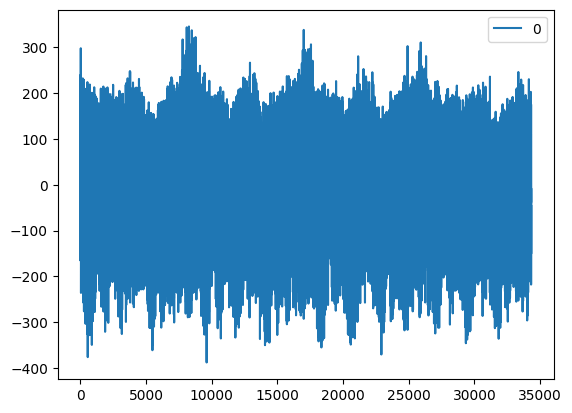

In [35]:
#Residual analysis
residuals_uni = pd.DataFrame(model_uni_params["residuals"])
residuals_uni.plot()
plt.show()

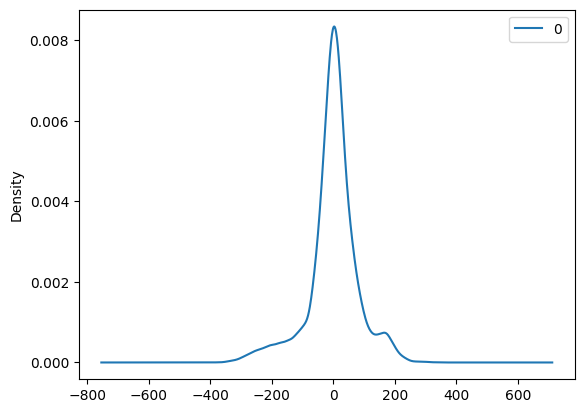

In [36]:
# Density plot of residuals
residuals_uni.plot(kind='kde')
plt.show()

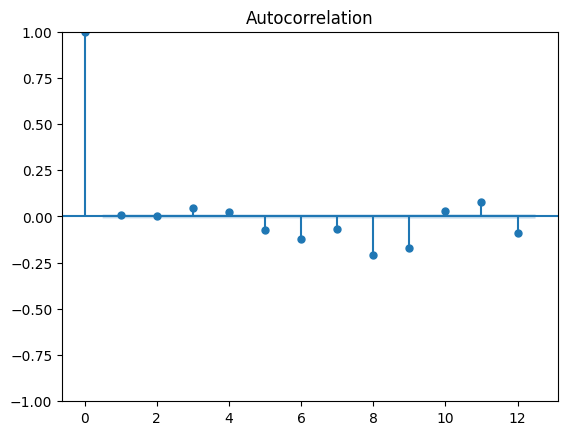

In [37]:
#Plot Autocorrelation of Residuals
plot_acf(residuals_uni, lags=12)
plt.show()

In [38]:
# Summary statistics of residuals
print(residuals_uni.describe())

                  0
count  34319.000000
mean      -0.000158
std       82.227274
min     -388.072128
25%      -30.185535
50%        3.239439
75%       37.771752
max      345.493011


**The mean of the residuals is zero and residuals seem to be uncorrelated. In addition, they seem to have a constant variance and are normally distributed.**

#### Forecasting univariate

In [40]:
#Get forecast
arima_forecast = sf_uni1.forecast(h=744, level=[95],fitted=True)
arima_forecast

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsforecast/core.py:399: FutureWarning: The `df` argument of the StatsForecast constructor as well as reusing stored dfs from other methods is deprecated and will raise an error in a future version. Please provide the `df` argument to the corresponding method instead, e.g. fit/forecast.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/utilsforecast/processing.py:374: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/utilsforecast/processing.py:428: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsforecast/c

,ds,AutoARIMA,AutoARIMA-lo-95,AutoARIMA-hi-95
unique_id,,,,
1,2014-12-01 00:00:00,2570.468262,2409.298828,2731.637939
1,2014-12-01 01:00:00,2489.439209,2081.665771,2897.212646
1,2014-12-01 02:00:00,2453.635010,1787.075562,3120.194580
1,2014-12-01 03:00:00,2441.124023,1535.723511,3346.524658
1,2014-12-01 04:00:00,2438.571289,1322.558350,3554.584229
...,...,...,...,...
1,2014-12-31 19:00:00,2442.535400,-15701.536133,20586.607422
1,2014-12-31 20:00:00,2442.535400,-15713.827148,20598.898438
1,2014-12-31 21:00:00,2442.535400,-15726.110352,20611.181641


In [41]:
#building essential column dataframe
arima_forecast_df =arima_forecast[['ds','AutoARIMA']]
arima_forecast_df.columns=[['ds','y_pred_uni']]

In [42]:
arima_forecast_df.head()

,ds,y_pred_uni
unique_id,,
1,2014-12-01 00:00:00,2570.468262
1,2014-12-01 01:00:00,2489.439209
1,2014-12-01 02:00:00,2453.635010
1,2014-12-01 03:00:00,2441.124023
1,2014-12-01 04:00:00,2438.571289


# Multivariate VAR

In [53]:
#P order selection for VAR model
var_model = VAR(df_main_st_train[['load_diff','T']])
for i in range(200,210):
    result = var_model.fit(i)
    print('Lag =', i)
    print('AIC : ', result.aic)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


Lag = 200
AIC :  6.8280098963315075
Lag = 201
AIC :  6.827944418012867
Lag = 202
AIC :  6.827774519801803
Lag = 203
AIC :  6.827932864620904
Lag = 204
AIC :  6.828115814380694
Lag = 205
AIC :  6.828260423043122
Lag = 206
AIC :  6.82846623987041
Lag = 207
AIC :  6.828243307262356
Lag = 208
AIC :  6.828117164220405
Lag = 209
AIC :  6.828254978280884


VAR Lag order will be 202

K-Cross Validation in VAR 

In [54]:
# Defining split and val_size for cross validation
n_splits = 10
val_size = 744

In [55]:
#Initialize TimeSeriesSplit object
tscv = TimeSeriesSplit(n_splits=n_splits, test_size=val_size)

In [128]:
#Print the indices considered in each split
for fold, (train_index, val_index) in enumerate(tscv.split(df_main_st_train)):
    print("Fold: {}".format(fold))
    print(f"TRAIN indices: {train_index.min()} to {train_index.max()} \n VALIDATION indices: {val_index.min()} to {val_index.max()}")
    print("\n")

Fold: 0
TRAIN indices: 0 to 26878 
 VALIDATION indices: 26879 to 27622


Fold: 1
TRAIN indices: 0 to 27622 
 VALIDATION indices: 27623 to 28366


Fold: 2
TRAIN indices: 0 to 28366 
 VALIDATION indices: 28367 to 29110


Fold: 3
TRAIN indices: 0 to 29110 
 VALIDATION indices: 29111 to 29854


Fold: 4
TRAIN indices: 0 to 29854 
 VALIDATION indices: 29855 to 30598


Fold: 5
TRAIN indices: 0 to 30598 
 VALIDATION indices: 30599 to 31342


Fold: 6
TRAIN indices: 0 to 31342 
 VALIDATION indices: 31343 to 32086


Fold: 7
TRAIN indices: 0 to 32086 
 VALIDATION indices: 32087 to 32830


Fold: 8
TRAIN indices: 0 to 32830 
 VALIDATION indices: 32831 to 33574


Fold: 9
TRAIN indices: 0 to 33574 
 VALIDATION indices: 33575 to 34318




In [56]:
#Checking dataframe
df_main_st_train.head()

,load,T,load_diff
DateTime,,,
2011-01-01 01:00:00,2525.0,32.666667,-142.0
2011-01-01 02:00:00,2417.0,34.000000,-108.0
2011-01-01 03:00:00,2373.0,36.000000,-44.0
2011-01-01 04:00:00,2374.0,36.000000,1.0
2011-01-01 05:00:00,2432.0,34.000000,58.0


In [76]:
#Initialize MAPE list
mape_ls_var = []

#Perform time series cross-validation
for fold, (train_index, val_index) in enumerate(tscv.split(df_main_st_train)):

    #Print fold number
    print("Fold: {}".format(fold))

    #Get train and validation fold
    train_fold_df = df_main_st_train.iloc[train_index]
    val_fold_df = df_main_st_train.iloc[val_index]


    #Fit the VAR model on training fold
    var_model = VAR (df_main_st_train[['load_diff','T']]).fit(202)

    #Predict for validation fold
    lag_order = 202
    var_forecast = var_model.forecast(df_main_st_train[['load_diff','T']].values[-lag_order:],744)[:,0]

    #Inversing the load diff
    var_forecast_df = pd.DataFrame(var_forecast, columns = ['dy_pred_VAR'])
    var_forecast_df['y_pred'] = train_fold_df['load'].iloc[-1] + var_forecast_df['dy_pred_VAR'].cumsum()
    #print(var_forecast_df)
    
    

    #Calculate and print MAPE
    val_fold_df["yhat"] = var_forecast_df['y_pred'].values
    mape = np.round(100*mean_absolute_percentage_error(val_fold_df["load"],val_fold_df["yhat"]),2)
    mape_ls_var.append(mape)
    print(f"The validation MAPE is {mape}%")

Fold: 0


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/var/folders/lt/216p_lfd1jx9d41r9mdhv2y00000gn/T/ipykernel_9557/1479156125.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_fold_df["yhat"] = var_forecast_df['y_pred'].values
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


The validation MAPE is 10.81%
Fold: 1


/var/folders/lt/216p_lfd1jx9d41r9mdhv2y00000gn/T/ipykernel_9557/1479156125.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_fold_df["yhat"] = var_forecast_df['y_pred'].values
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


The validation MAPE is 6.06%
Fold: 2


/var/folders/lt/216p_lfd1jx9d41r9mdhv2y00000gn/T/ipykernel_9557/1479156125.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_fold_df["yhat"] = var_forecast_df['y_pred'].values
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


The validation MAPE is 10.5%
Fold: 3


/var/folders/lt/216p_lfd1jx9d41r9mdhv2y00000gn/T/ipykernel_9557/1479156125.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_fold_df["yhat"] = var_forecast_df['y_pred'].values
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


The validation MAPE is 5.97%
Fold: 4


/var/folders/lt/216p_lfd1jx9d41r9mdhv2y00000gn/T/ipykernel_9557/1479156125.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_fold_df["yhat"] = var_forecast_df['y_pred'].values
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


The validation MAPE is 6.56%
Fold: 5


/var/folders/lt/216p_lfd1jx9d41r9mdhv2y00000gn/T/ipykernel_9557/1479156125.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_fold_df["yhat"] = var_forecast_df['y_pred'].values
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


The validation MAPE is 8.93%
Fold: 6


/var/folders/lt/216p_lfd1jx9d41r9mdhv2y00000gn/T/ipykernel_9557/1479156125.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_fold_df["yhat"] = var_forecast_df['y_pred'].values
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


The validation MAPE is 6.71%
Fold: 7


/var/folders/lt/216p_lfd1jx9d41r9mdhv2y00000gn/T/ipykernel_9557/1479156125.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_fold_df["yhat"] = var_forecast_df['y_pred'].values
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


The validation MAPE is 8.01%
Fold: 8


/var/folders/lt/216p_lfd1jx9d41r9mdhv2y00000gn/T/ipykernel_9557/1479156125.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_fold_df["yhat"] = var_forecast_df['y_pred'].values
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


The validation MAPE is 4.98%
Fold: 9
The validation MAPE is 5.42%


/var/folders/lt/216p_lfd1jx9d41r9mdhv2y00000gn/T/ipykernel_9557/1479156125.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_fold_df["yhat"] = var_forecast_df['y_pred'].values


In [77]:
#The cross-validation error
crossval_mape_var = np.mean(mape_ls_var)
print("The 10-fold cross-validation MAPE with expanding window approach is {}%".format(crossval_mape_var))

The 10-fold cross-validation MAPE with expanding window approach is 7.3950000000000005%


In [57]:
# final fit of the order after selecting order
var_model_final = VAR (df_main_st_train[['load_diff','T']]).fit(202)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


In [58]:
#reviewing summary of var output
var_model_final.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 21, Jun, 2024
Time:                     10:53:33
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    7.02810
Nobs:                     34117.0    HQIC:                   6.89166
Log likelihood:          -212481.    FPE:                    923.136
AIC:                      6.82777    Det(Omega_mle):         901.603
--------------------------------------------------------------------
Results for equation load_diff
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                 -0.398711         0.447973           -0.890           0.373
L1.load_diff           0.660826         0.005452          121.211           0.000
L1.T                  -0.501910         0.143503    

### VAR Residual Diagnostics

<Axes: xlabel='DateTime'>

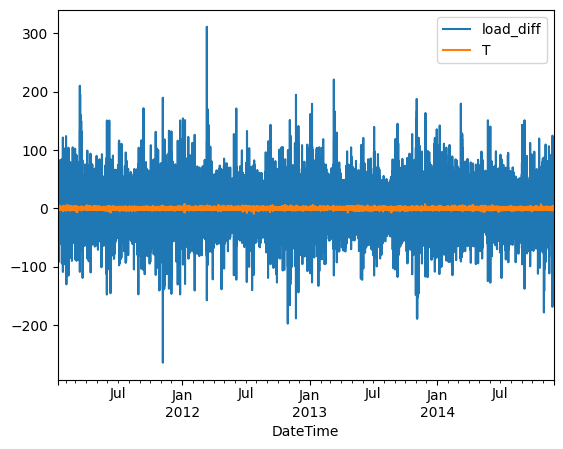

In [156]:
# Residual analysis
residuals_var = pd.DataFrame(var_model_final.resid)
residuals_var.plot()
#residuals_var.head()

<Axes: ylabel='Density'>

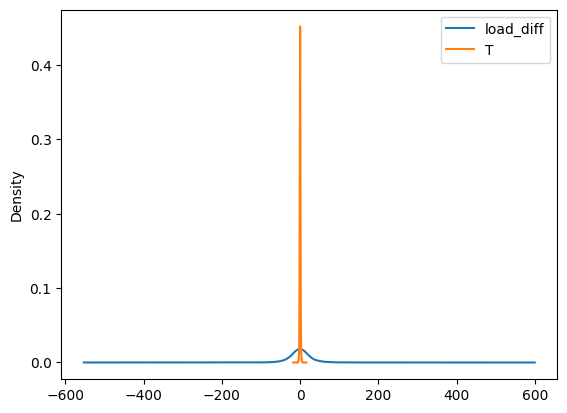

In [158]:
# Density plot of residuals
residuals_var.plot(kind = 'kde')

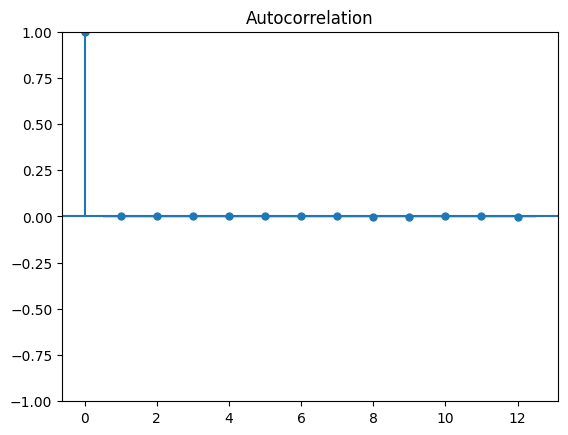

In [159]:
# plot autocorrelation of residuals-> load
plot_acf(residuals_var['load_diff'],lags=12)
plt.show()

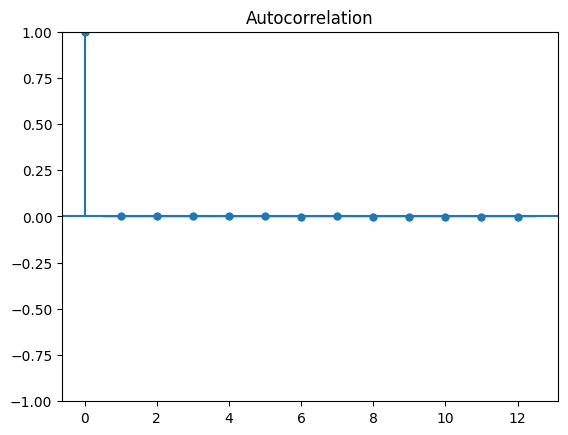

In [160]:
# plot autocorrelation of residuals-> T
plot_acf(residuals_var['T'],lags=12)
plt.show()

In [ ]:
#summary stats of residuals
print(residuals_var.describe())

In [75]:
#Feed input data for last 202 hours since VAR model terms are lags
lag_order = 202
var_forecast = var_model_final.forecast(df_main_st_train[['load_diff','T']].values[-lag_order:],744)[:,0]
var_forecast

array([-1.63457289e+02, -8.56941809e+01, -4.27056085e+01, -2.46961971e-02,
        7.50561817e+01,  2.46978599e+02,  3.61744160e+02,  2.36035310e+02,
        1.16752153e+02,  7.19564581e+01,  2.83498514e+01, -1.94006305e+01,
       -5.82827704e+01, -4.33533707e+01, -3.27718616e+01,  4.46227986e+01,
        2.30064991e+02,  1.20536231e+02, -3.03432258e+01, -9.44901494e+01,
       -1.46442534e+02, -2.67486140e+02, -2.93218363e+02, -2.43140684e+02,
       -1.68634587e+02, -8.48962383e+01, -3.18506588e+01,  1.37730339e+01,
        8.18384116e+01,  2.70749981e+02,  3.93442434e+02,  2.17832089e+02,
        6.18529980e+01,  2.14079129e+01,  1.77088769e+01, -3.24752040e+00,
       -2.52549227e+01, -1.00900564e+01, -2.17414598e+01,  3.07445203e+01,
        2.34502028e+02,  1.51081227e+02, -2.23197131e+01, -1.11348644e+02,
       -1.47099062e+02, -2.54383331e+02, -2.83427599e+02, -2.34378815e+02,
       -1.52331073e+02, -8.14286832e+01, -3.05220124e+01,  3.32396466e+01,
        7.47555469e+01,  

**Add inverse **

In [162]:
type(pd.Series(var_forecast))

pandas.core.series.Series

### Inversing the predicted values to get y

In [61]:
#creating dataframe to capture forecasts
var_forecast_df = pd.DataFrame(var_forecast, columns = ['dy_pred_VAR'])

In [164]:
#getting timestamps
pd.Series(df_main_st_test.index)

0     2014-12-01 00:00:00
1     2014-12-01 01:00:00
2     2014-12-01 02:00:00
3     2014-12-01 03:00:00
4     2014-12-01 04:00:00
              ...        
739   2014-12-31 19:00:00
740   2014-12-31 20:00:00
741   2014-12-31 21:00:00
742   2014-12-31 22:00:00
743   2014-12-31 23:00:00
Name: DateTime, Length: 744, dtype: datetime64[ns]

In [62]:
#adding date to result dataframe
var_forecast_df['date'] = [df_main_st_test.index[i] for i in range(len(df_main_st_test))]

In [63]:
#capturing y_red and actuals to dataframe
var_forecast_df['y_pred'] = df_main_st_train['load'].iloc[-1] + var_forecast_df['dy_pred_VAR'].cumsum()
var_forecast_df['y_actuals']=df_main_st_test['load'].values

In [64]:
#cheking dataframe
var_forecast_df.head()

,dy_pred_VAR,date,y_pred,y_actuals
0,-163.457289,2014-12-01 00:00:00,2559.542711,2580.0
1,-85.694181,2014-12-01 01:00:00,2473.848530,2505.0
2,-42.705608,2014-12-01 02:00:00,2431.142921,2482.0
3,-0.024696,2014-12-01 03:00:00,2431.118225,2482.0
4,75.056182,2014-12-01 04:00:00,2506.174407,2586.0


# Benchmark models

In [43]:
#Initialize empty models list that we'll add models to
models_benchmark = []

In [44]:
#Average model
models_benchmark.append(HistoricAverage(alias="Average"))

#Seasonal Naive model
models_benchmark.append(SeasonalNaive(season_length=365*24, alias="Seasonal Naive"))

In [45]:
# Initializing our models
train_data =  df_main_uni_st_train[:-744] 

sf_benchmark = StatsForecast(df=train_data,
                   models=models_benchmark,
                   freq='H', # Hourly frequency
                   n_jobs=-1,
                   fallback_model=HistoricAverage)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsforecast/core.py:399: FutureWarning: The `df` argument of the StatsForecast constructor as well as reusing stored dfs from other methods is deprecated and will raise an error in a future version. Please provide the `df` argument to the corresponding method instead, e.g. fit/forecast.
  warnings.warn(


In [47]:
#Fit the model
sf_benchmark.fit()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsforecast/core.py:399: FutureWarning: The `df` argument of the StatsForecast constructor as well as reusing stored dfs from other methods is deprecated and will raise an error in a future version. Please provide the `df` argument to the corresponding method instead, e.g. fit/forecast.
  warnings.warn(


StatsForecast(models=[Average,Seasonal Naive])

In [48]:
#capturing model wise outputs
result_avg = sf_benchmark.fitted_[0,0].model_
result_snaive = sf_benchmark.fitted_[0,1].model_

In [216]:
#Extract only fitted values from the models into a dataframe
fitted_df = pd.DataFrame()

#Also have the timestamp
fitted_df["ds"]=train_data["ds"]

fitted_df["fitted_avg"] = result_avg.get("fitted")
fitted_df["fitted_snaive"] = result_snaive.get("fitted")


In [50]:
#Forecast
Y_hat_benchmark = sf_benchmark.forecast(h=744, fitted=True)
Y_hat_benchmark.head()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/utilsforecast/processing.py:374: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/utilsforecast/processing.py:428: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsforecast/core.py:417: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


,ds,Average,Seasonal Naive
unique_id,,,
1,2014-10-31 00:00:00,3290.783936,2638.0
1,2014-10-31 01:00:00,3290.783936,2522.0
1,2014-10-31 02:00:00,3290.783936,2487.0
1,2014-10-31 03:00:00,3290.783936,2490.0
1,2014-10-31 04:00:00,3290.783936,2589.0


# Overall comparison

In [51]:
models_complete = ['AutoARIMA', 'VAR','HistoricAverage','SeasonalNaive']

In [72]:
Y_hat_final = pd.DataFrame()
Y_hat_final['AutoARIMA'] = arima_forecast_df['y_pred_uni']
Y_hat_final['VAR'] = var_forecast_df['y_pred']
Y_hat_final['HistoricAverage'] = Y_hat_benchmark['Average']
Y_hat_final['SeasonalNaive'] = Y_hat_benchmark['Seasonal Naive']


In [74]:
Y_hat_final

,AutoARIMA,VAR,HistoricAverage,SeasonalNaive
unique_id,,,,
1,2570.468262,2464.84853,3290.783936,2638.0
1,2489.439209,2464.84853,3290.783936,2522.0
1,2453.635010,2464.84853,3290.783936,2487.0
1,2441.124023,2464.84853,3290.783936,2490.0
1,2438.571289,2464.84853,3290.783936,2589.0
...,...,...,...,...
1,2442.535400,2464.84853,3290.783936,3881.0
1,2442.535400,2464.84853,3290.783936,3769.0
1,2442.535400,2464.84853,3290.783936,3560.0


In [86]:
#Get the actual 744 values of forecast duration
actual_ts = df_main_st_test["load"]

#Create a list with the model aliases
model_names = [str(model) for model in models_complete]

#Initialize error dataframe
error_df = pd.DataFrame(columns=model_names, )

#Print the errors for each model
for model in model_names:
   
    #Evaluate the model MAPE
    if model == 'AutoARIMA' :
        model_mape = crossval_mape_arima
    elif model == 'VAR':
        model_mape = crossval_mape_var
    else: 
        model_mape = np.round(100*mean_absolute_percentage_error(actual_ts, Y_hat_final[model]),2)
    print(f'{model},has MAPE value of -> MAPE {model_mape:.2f}')

AutoARIMA,has MAPE value of -> MAPE 21.73
VAR,has MAPE value of -> MAPE 7.40
HistoricAverage,has MAPE value of -> MAPE 14.05
SeasonalNaive,has MAPE value of -> MAPE 9.61
